In [2]:
import numpy as np
from utils_clean import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func)

Variation of n_particles

In [3]:
import pandas as pd
df_results = pd.DataFrame({"Iteration":[], "n_particles":[], "t1":[], "t2":[], "Log Likelihood":[]})

In [4]:
n_particles = [5, 10, 20, 40, 65, 100]

for i in range(20):
    for n_p in n_particles:
        pso = PSOOptim(n_iters=10, n_particles=n_p, c1=0.5, c2=0.3, w=0.9, visualize=True)
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_pso.fit(X.T, y[...,None])
        df_results.loc[len(df_results)] = [i, n_p, gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], gpr_pso.log_marginal_likelihood_value_]


2022-08-09 10:03:01,379 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=4.9e+4
2022-08-09 10:03:01,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 48974.97066510525, best pos: [-0.56184526 -2.74941188]
2022-08-09 10:03:01,517 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.5e+4
2022-08-09 10:03:01,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34980.8839014496, best pos: [-1.20060391 -1.13800357]
2022-08-09 10:03:01,715 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.61e+4
2022-08-09 10:03:02,029 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36087.346963782205, 

In [5]:
df_results

,Iteration,n_particles,t1,t2,Log Likelihood
0,0.0,5.0,-0.561845,-2.749412,-48974.970665
1,0.0,10.0,-1.200604,-1.138004,-34980.883901
2,0.0,20.0,-0.929021,-1.397435,-36087.346964
3,0.0,40.0,-1.077972,-1.299719,-35408.123489
4,0.0,65.0,-1.112153,-1.053846,-34318.754830
...,...,...,...,...,...
115,19.0,10.0,-1.375586,-0.940978,-36527.489871
116,19.0,20.0,-1.051276,-0.965453,-34878.534838
117,19.0,40.0,-0.983936,-1.022070,-34575.172924
118,19.0,65.0,-0.962443,-1.103252,-34365.207286


In [6]:
df_results_ = df_results.groupby(['n_particles'], as_index=False).agg({'Log Likelihood':['mean','std']})

In [7]:
df_results_

n_particles Log Likelihood             
                        mean          std
0         5.0  -52283.706294  9510.548016
1        10.0  -43787.754491  8780.482849
2        20.0  -36695.142092  3432.766931
3        40.0  -34919.798590   563.086407
4        65.0  -34514.714030   456.503091
5       100.0  -34565.781756   417.469965

In [8]:
from scipy.stats import t
df_results_["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood"]["std"] + df_results_["Log Likelihood"]["mean"]
df_results_["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood"]["std"] + df_results_["Log Likelihood"]["mean"]

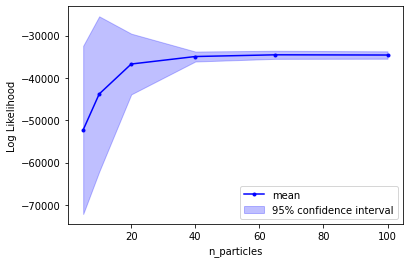

In [17]:
plt.plot(df_results_["n_particles"], df_results_["Log Likelihood"]["mean"], color="b", label="mean", marker='o', markersize=3)
plt.fill_between(df_results_["n_particles"], df_results_["conf_95_u"], df_results_["conf_95_o"], color="b", alpha=.25, label="95% confidence interval")
plt.xlabel("n_particles")
plt.ylabel("Log Likelihood")
plt.legend(loc="lower right")

Variation of iterations

In [25]:
df_results_i = pd.DataFrame({"Iteration":[], "n_iters":[], "t1":[], "t2":[], "Log Likelihood":[]})

In [26]:
n_iters = [5, 10, 25, 50, 100, 200, 500]

for i in range(20):
    for n_i in n_iters:
        pso = PSOOptim(n_iters=n_i, n_particles=10, c1=0.5, c2=0.3, w=0.9, visualize=True)
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_pso.fit(X.T, y[...,None])
        df_results_i.loc[len(df_results_i)] = [i, n_i, gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], gpr_pso.log_marginal_likelihood_value_]

2022-08-09 10:31:32,371 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=4.4e+4 
2022-08-09 10:31:32,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 43975.2851543129, best pos: [-0.58265138 -1.65868487]
2022-08-09 10:31:32,512 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=5.34e+4
2022-08-09 10:31:32,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 53404.244180735026, best pos: [ 0.07603789 -3.30017416]
2022-08-09 10:31:32,731 - pyswarms.single.global_best - INFO - Optimize for 25 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|25/25, best_cost=3.42e+4
2022-08-09 10:31:33,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34171.09747848839, b

In [27]:
df_results_i_ = df_results_i.groupby(['n_iters'], as_index=False).agg({'Log Likelihood':['mean','std']})

In [28]:
df_results_i_["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * df_results_i_["Log Likelihood"]["std"] + df_results_i_["Log Likelihood"]["mean"]
df_results_i_["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * df_results_i_["Log Likelihood"]["std"] + df_results_i_["Log Likelihood"]["mean"]

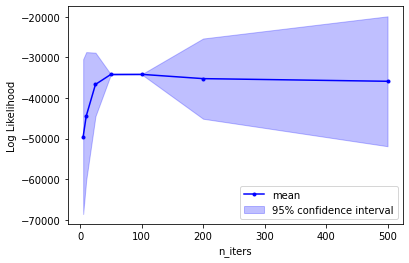

In [29]:
plt.plot(df_results_i_["n_iters"], df_results_i_["Log Likelihood"]["mean"], color="b", label="mean", marker='o', markersize=3)
plt.fill_between(df_results_i_["n_iters"], df_results_i_["conf_95_u"], df_results_i_["conf_95_o"], color="b", alpha=.25, label="95% confidence interval")
plt.xlabel("n_iters")
plt.ylabel("Log Likelihood")
plt.legend(loc="lower right")

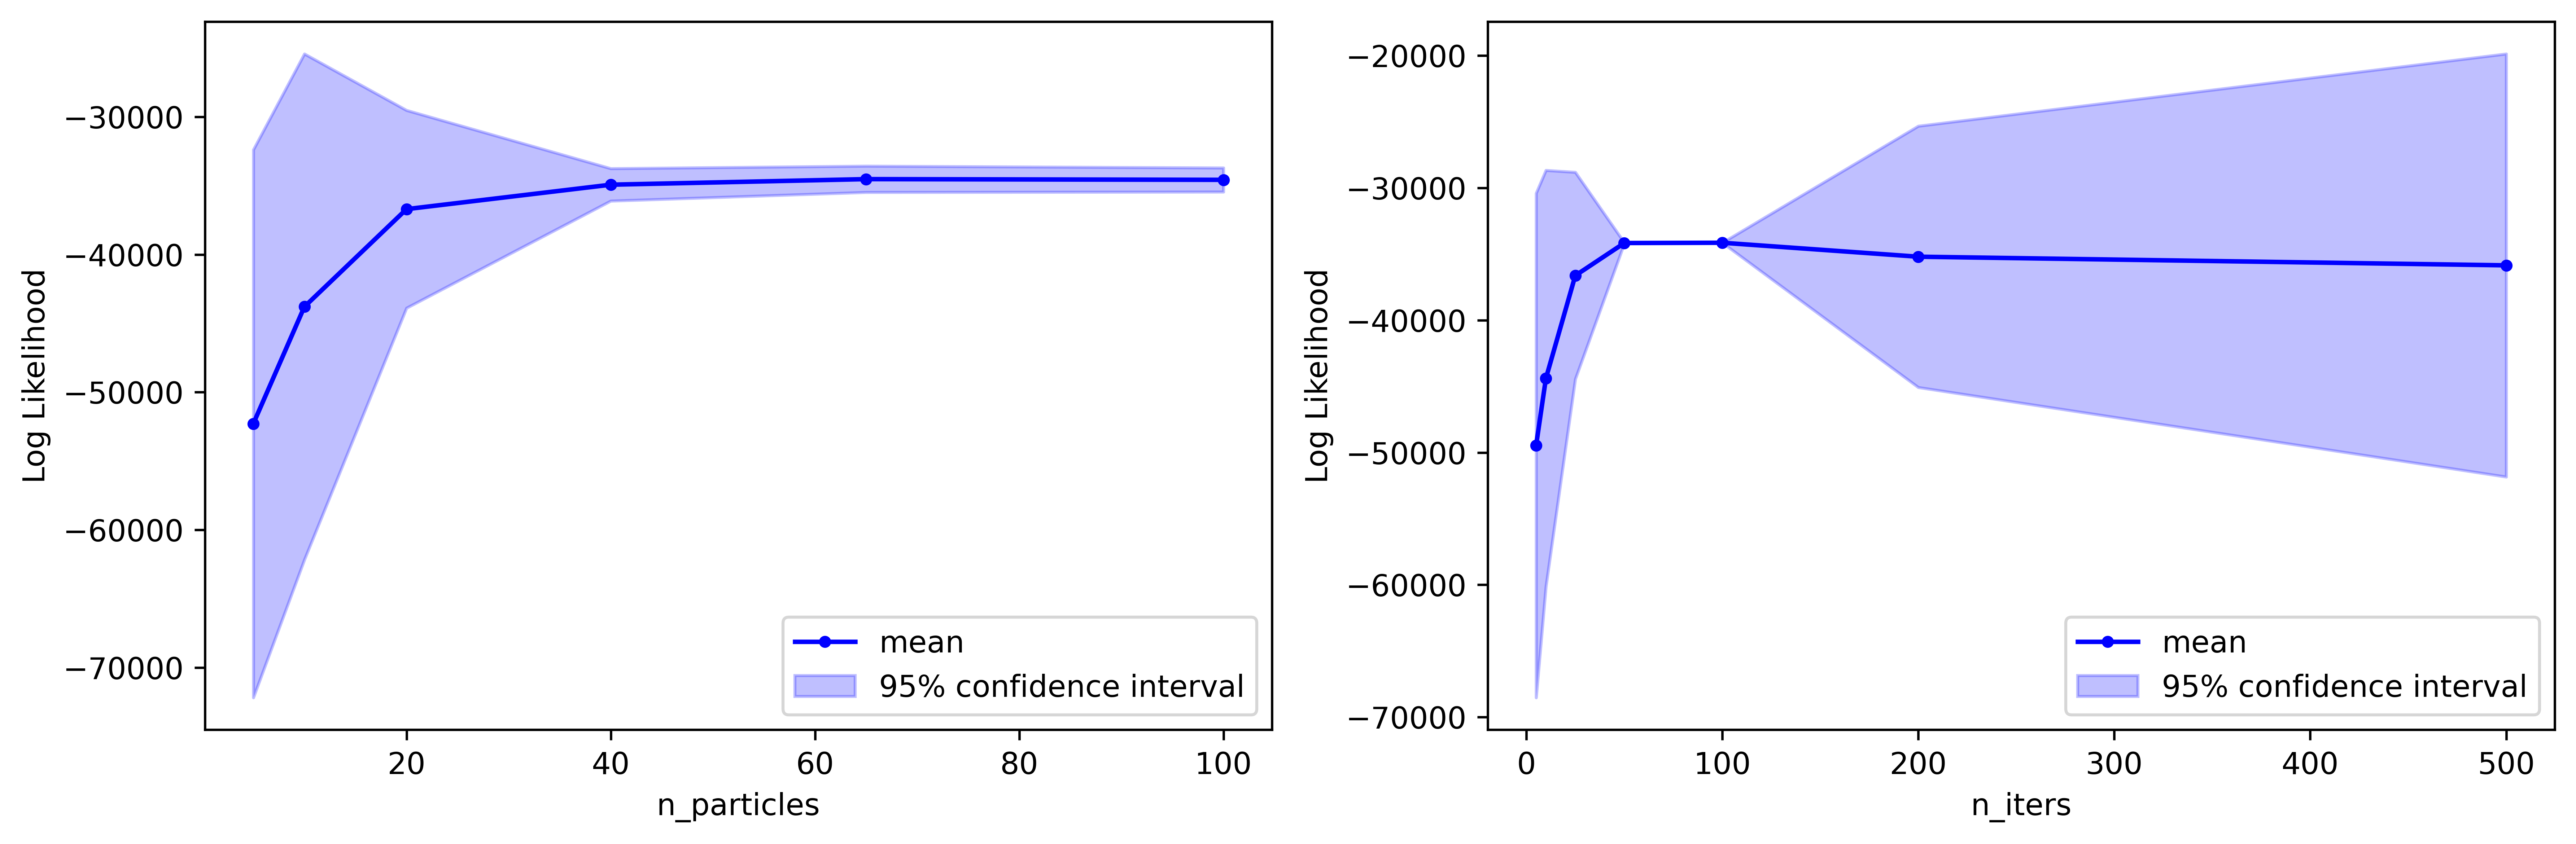

In [32]:
plt.figure(figsize=(12,4), dpi=600)
plt.subplot(121)
plt.plot(df_results_["n_particles"], df_results_["Log Likelihood"]["mean"], color="b", label="mean", marker='o', markersize=3)
plt.fill_between(df_results_["n_particles"], df_results_["conf_95_u"], df_results_["conf_95_o"], color="b", alpha=.25, label="95% confidence interval")
plt.xlabel("n_particles")
plt.ylabel("Log Likelihood")
plt.legend(loc="lower right")
plt.subplot(122)
plt.plot(df_results_i_["n_iters"], df_results_i_["Log Likelihood"]["mean"], color="b", label="mean", marker='o', markersize=3)
plt.fill_between(df_results_i_["n_iters"], df_results_i_["conf_95_u"], df_results_i_["conf_95_o"], color="b", alpha=.25, label="95% confidence interval")
plt.xlabel("n_iters")
plt.ylabel("Log Likelihood")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Variation of inertia

In [48]:
df_results_in = pd.DataFrame({"Iteration":[], "inertia":[], "Log Likelihood":[]})

In [49]:
inertias = [0, .3, .6, .9, 1.2, 1.5]

for i in range(20):
    for inertia in inertias:
        pso = PSOOptim(n_iters=100, n_particles=10, c1=0.5, c2=0.3, w=inertia, visualize=True)
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_pso.fit(X.T, y[...,None])
        df_results_in.loc[len(df_results_in)] = [i, inertia, gpr_pso.log_marginal_likelihood_value_]

2022-08-09 11:23:05,772 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.2e+4
2022-08-09 11:23:07,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 42036.13478040644, best pos: [-0.91378863 -1.87904281]
2022-08-09 11:23:07,810 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.3}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.44e+4
2022-08-09 11:23:09,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44381.68397426576, best pos: [-2.68879963 -0.17304294]
2022-08-09 11:23:09,462 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.41e+4
2022-08-09 11:23:11,059 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34146.92764

In [50]:
df_results_in_ = df_results_in.groupby(['inertia'], as_index=False).agg({'Log Likelihood':['mean','std']})

In [51]:
df_results_in_["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * df_results_in_["Log Likelihood"]["std"] + df_results_in_["Log Likelihood"]["mean"]
df_results_in_["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * df_results_in_["Log Likelihood"]["std"] + df_results_in_["Log Likelihood"]["mean"]

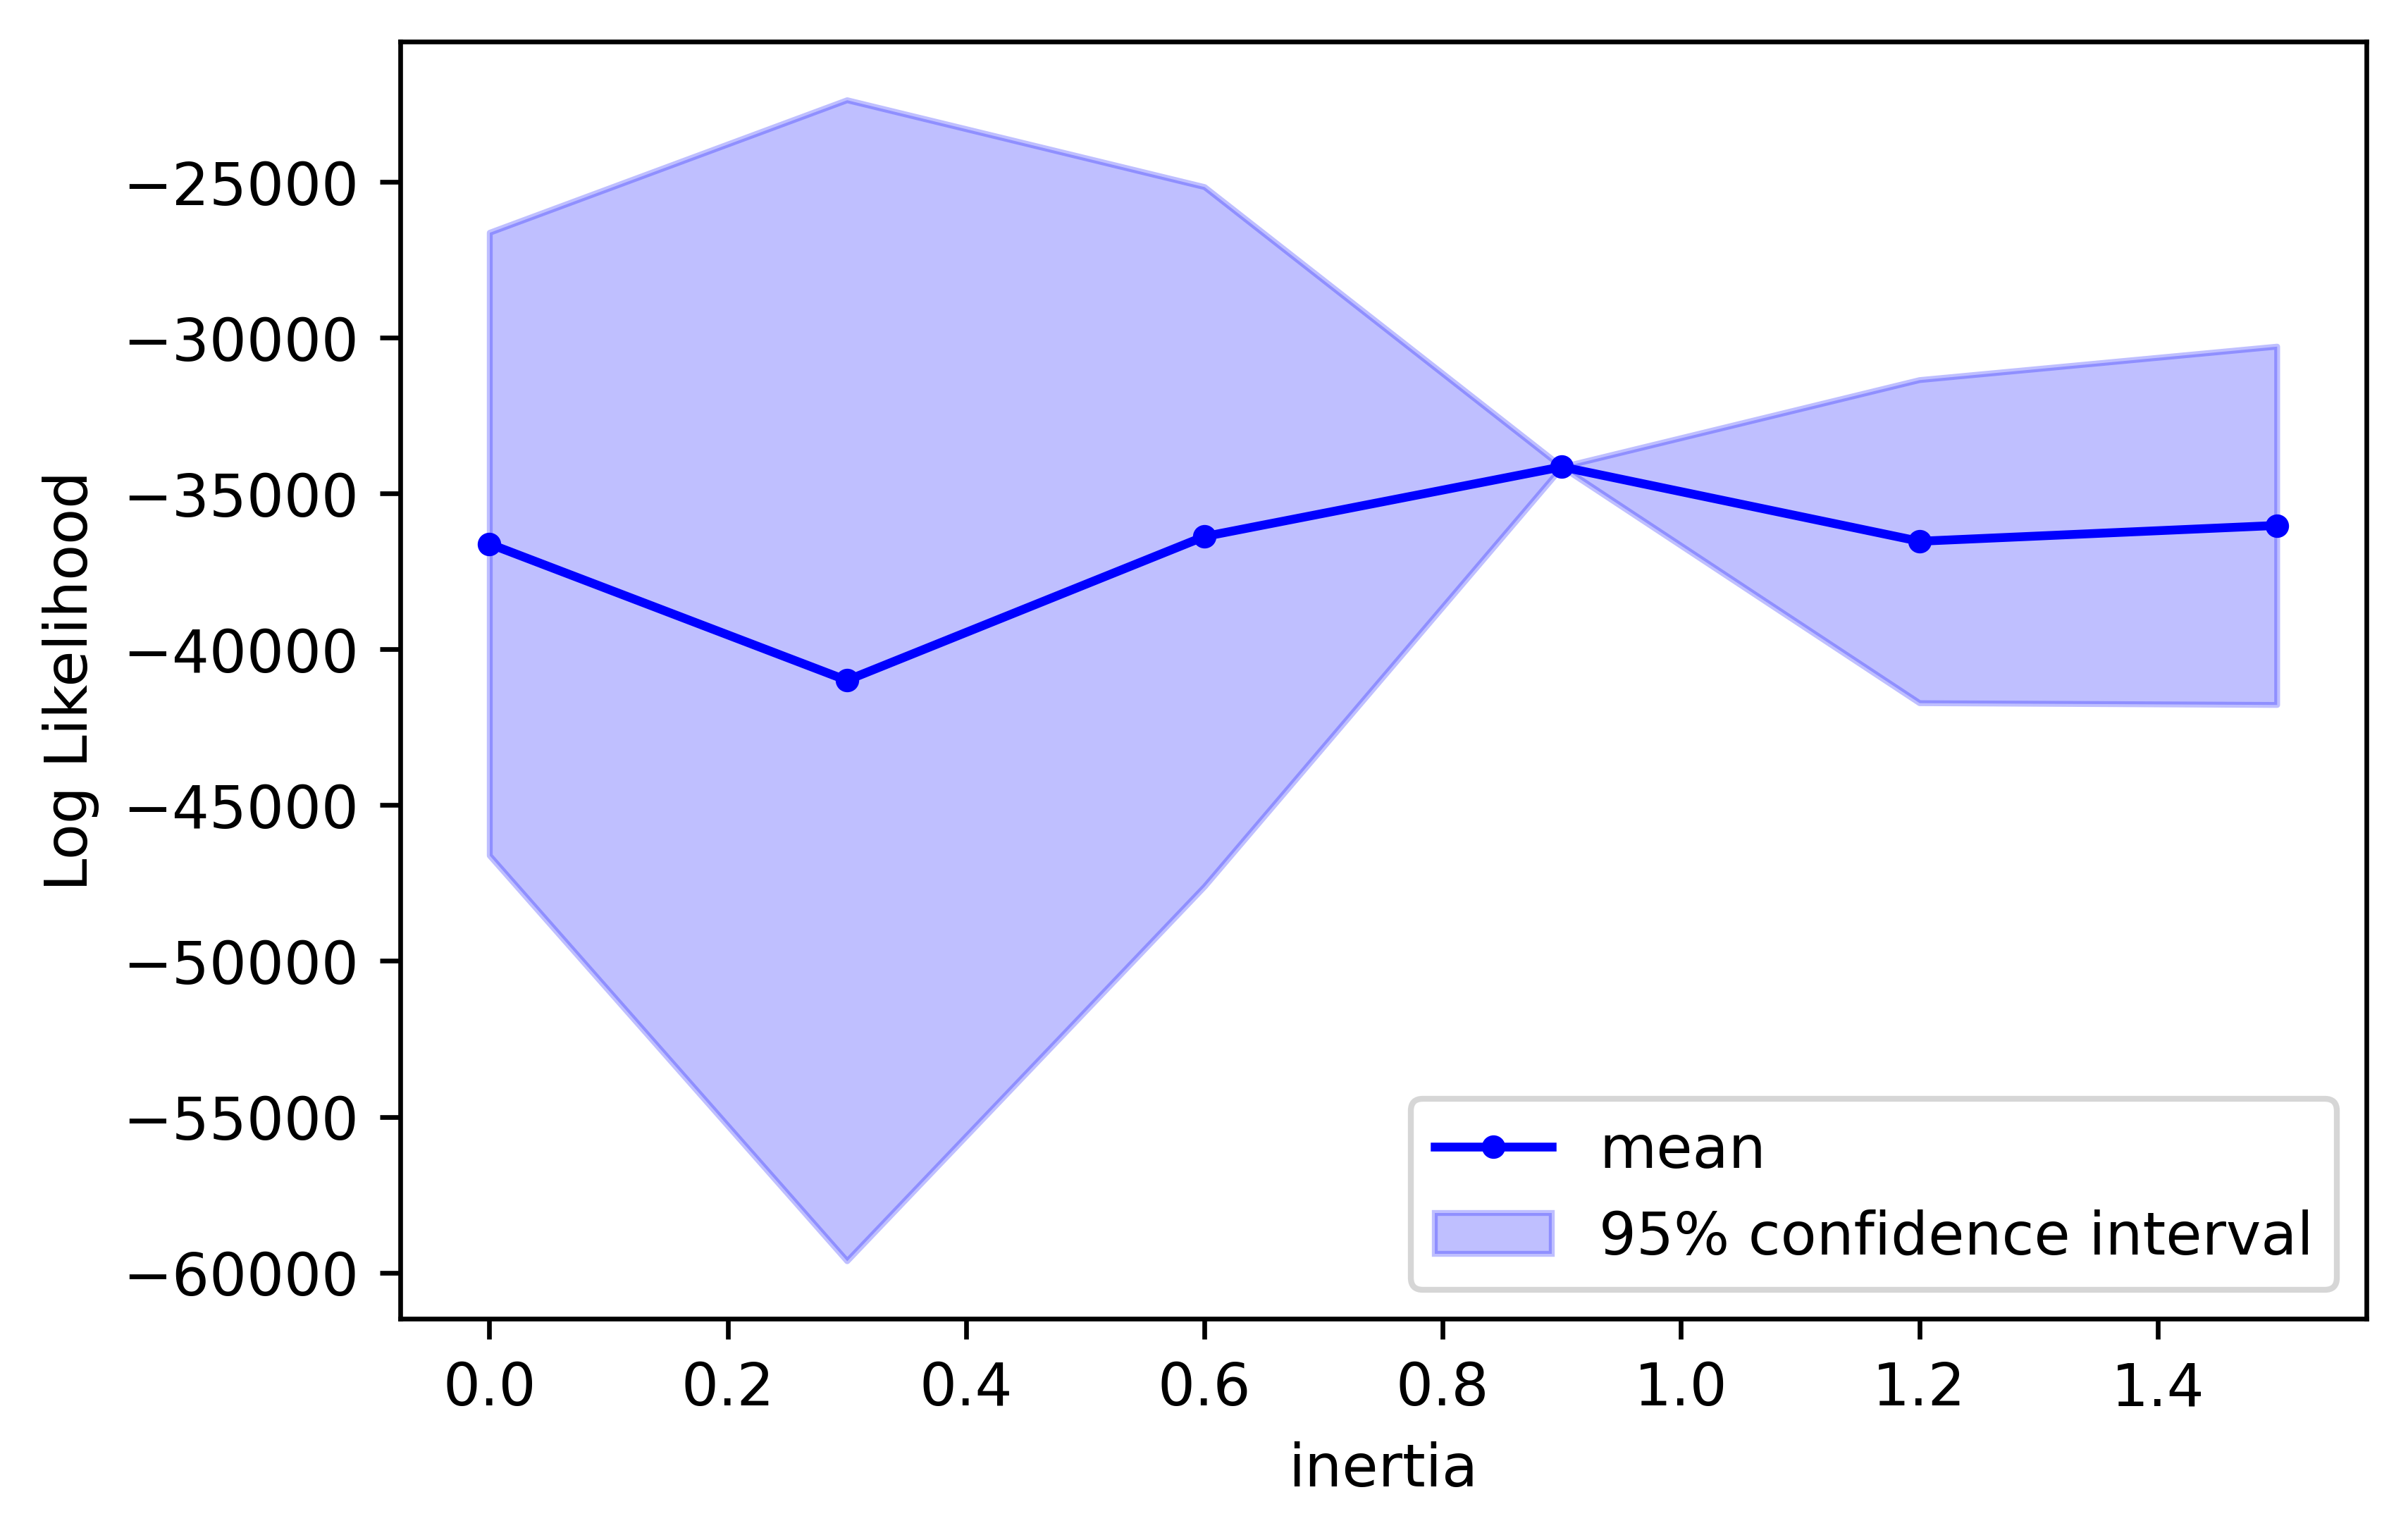

In [53]:
plt.figure(dpi=600)
plt.plot(df_results_in_["inertia"], df_results_in_["Log Likelihood"]["mean"], color="b", label="mean", marker='o', markersize=3)
plt.fill_between(df_results_in_["inertia"], df_results_in_["conf_95_u"], df_results_in_["conf_95_o"], color="b", alpha=.25, label="95% confidence interval")
plt.xlabel("inertia")
plt.ylabel("Log Likelihood")
plt.legend(loc="lower right")

Exploration vs. Exploitation

In [64]:
pso = PSOOptim(n_iters=100, n_particles=10, c1=3, c2=0, w=0.9, visualize=True)
gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
gpr_pso.fit(X.T, y[...,None]);

2022-08-09 14:11:55,884 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 3, 'c2': 0, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.48e+4
2022-08-09 14:11:58,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34800.5623148287, best pos: [-1.20064    -1.08563272]


100%|██████████| 10000/10000 [00:17<00:00, 585.80it/s]
2022-08-09 14:12:15,756 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2022-08-09 14:12:15,756 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


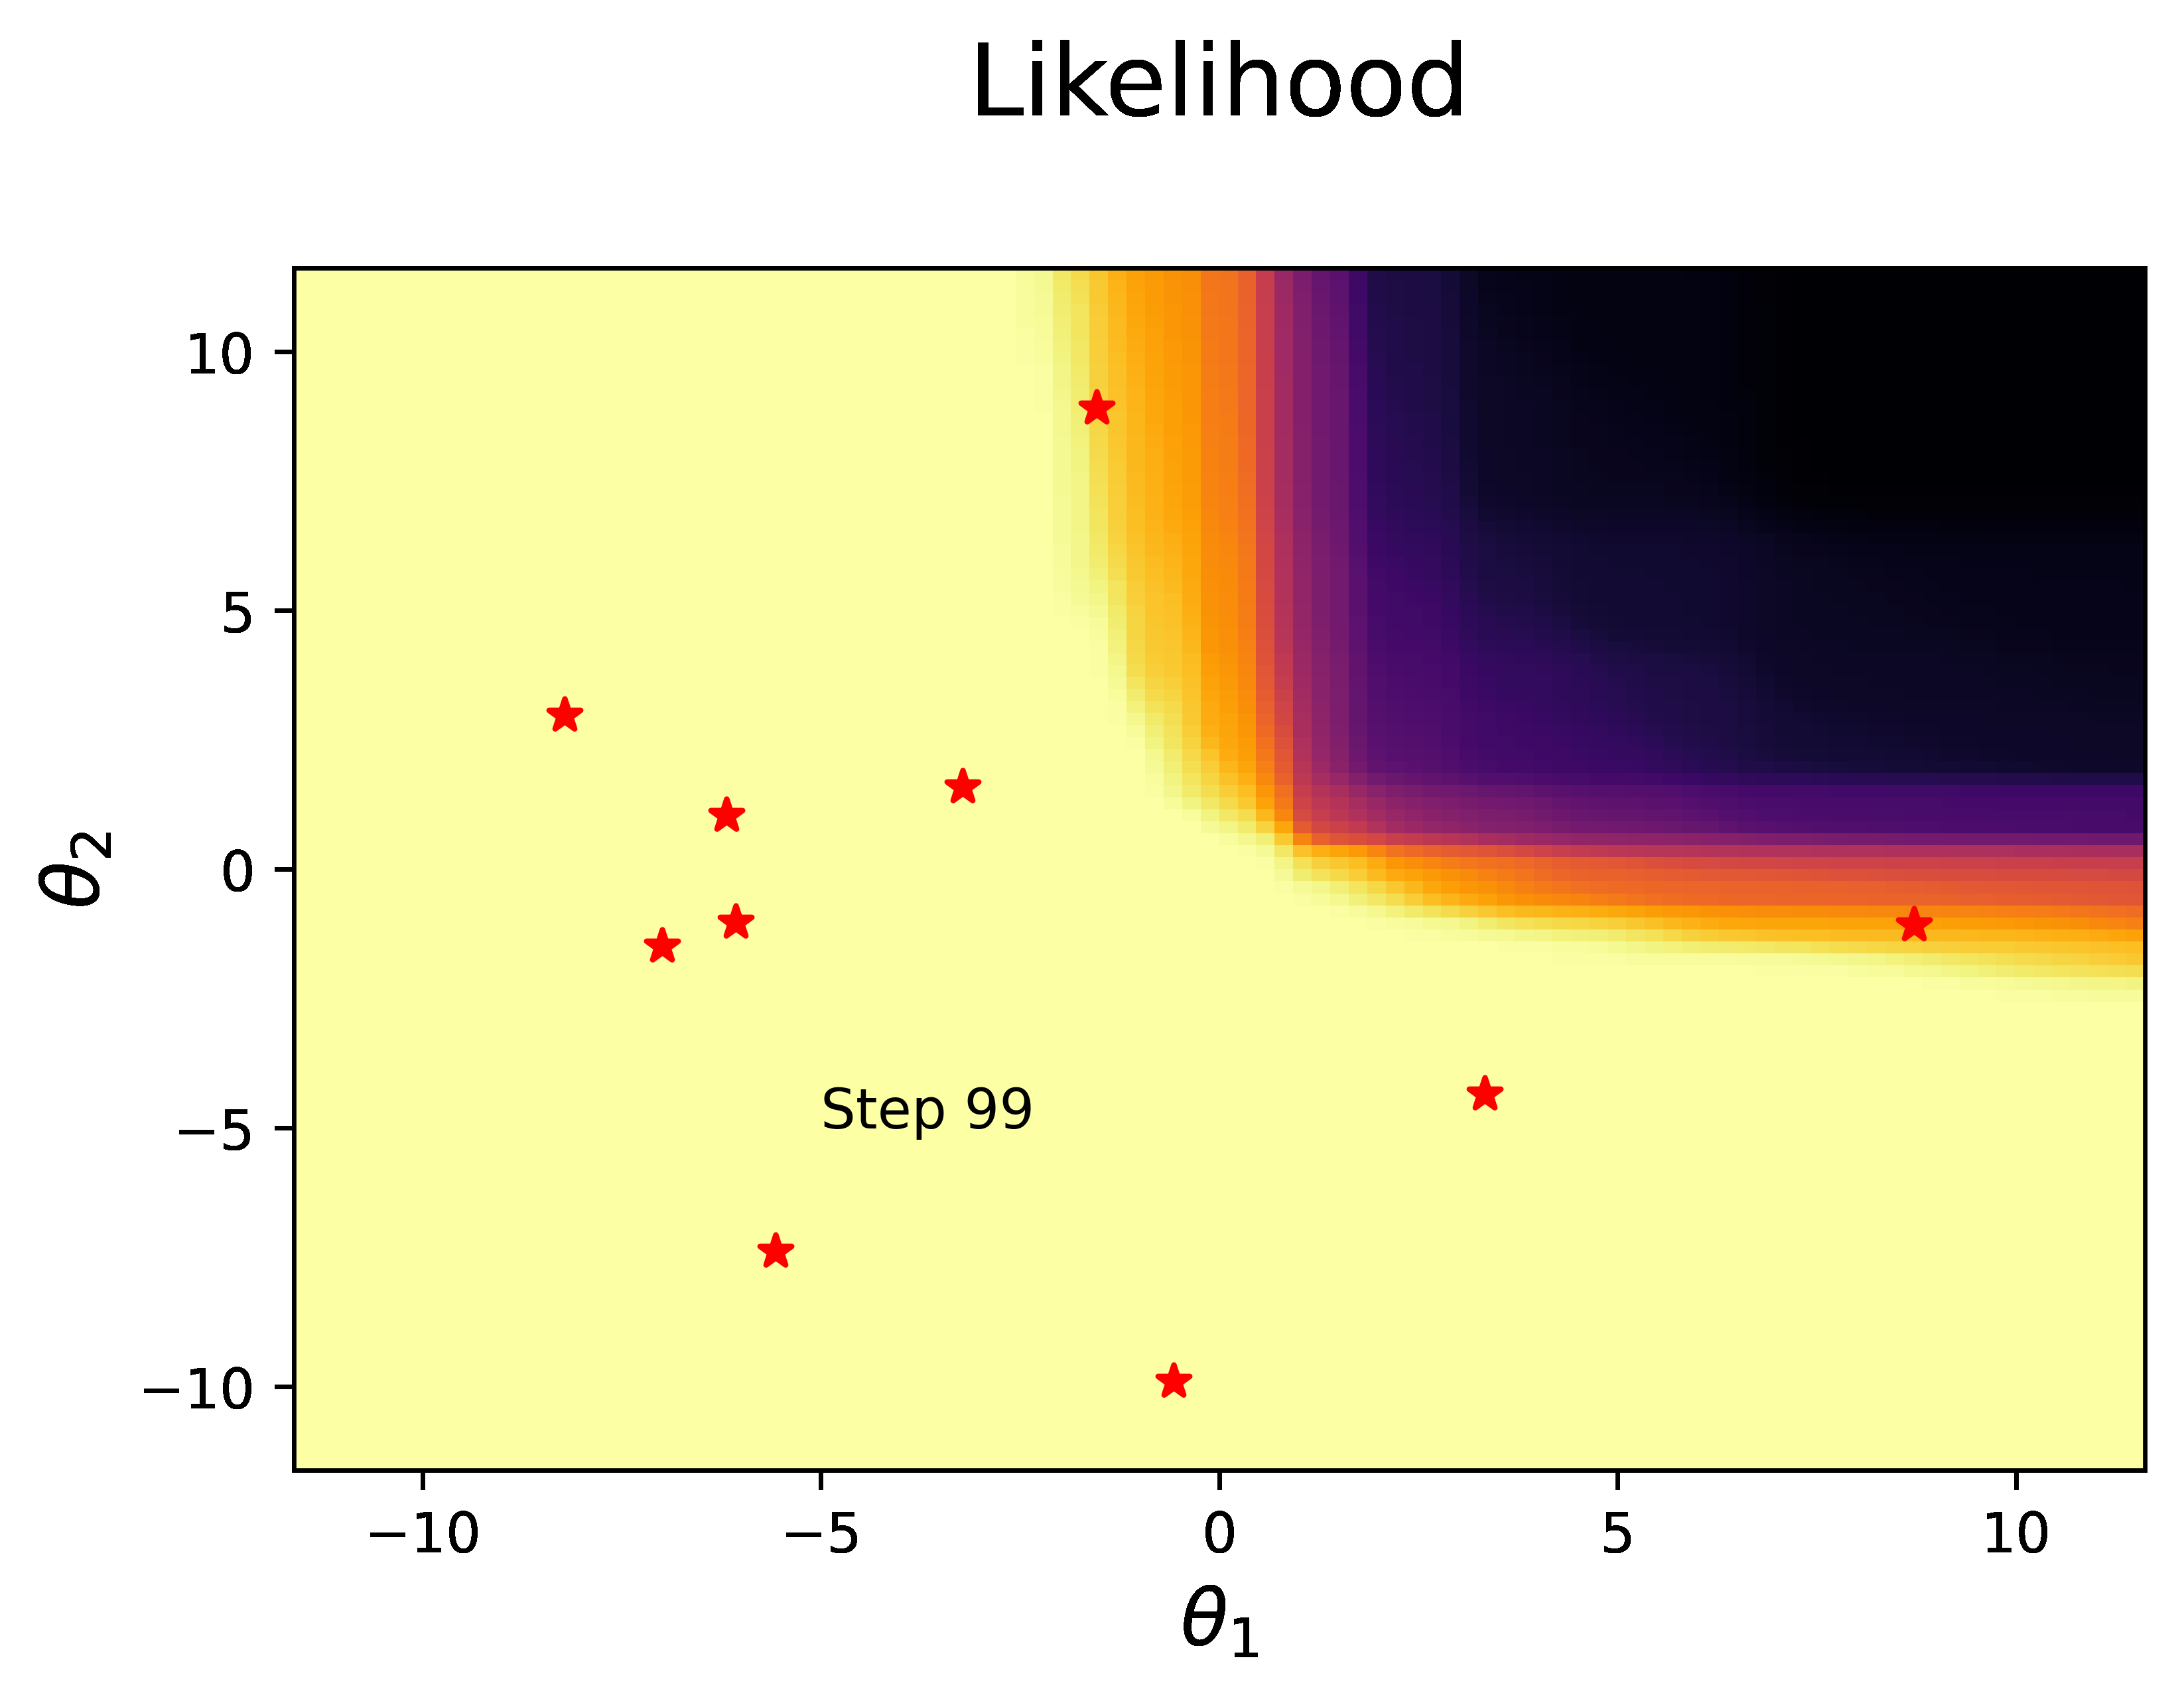

In [65]:
from utils_clean import get_likelihood_grids
x_grid, y_grid, z_grid = get_likelihood_grids(gpr_pso)
pso.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO_c1is3_c2is0.gif", show_zaeff=False)

In [66]:
pso = PSOOptim(n_iters=100, n_particles=10, c1=0, c2=3, w=0.9, visualize=True)
gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
gpr_pso.fit(X.T, y[...,None]);

2022-08-09 14:24:04,225 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0, 'c2': 3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.54e+4
2022-08-09 14:24:05,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35388.646078355414, best pos: [-0.91679894 -1.30828141]


100%|██████████| 10000/10000 [00:06<00:00, 1480.94it/s]
2022-08-09 14:24:12,205 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2022-08-09 14:24:12,206 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


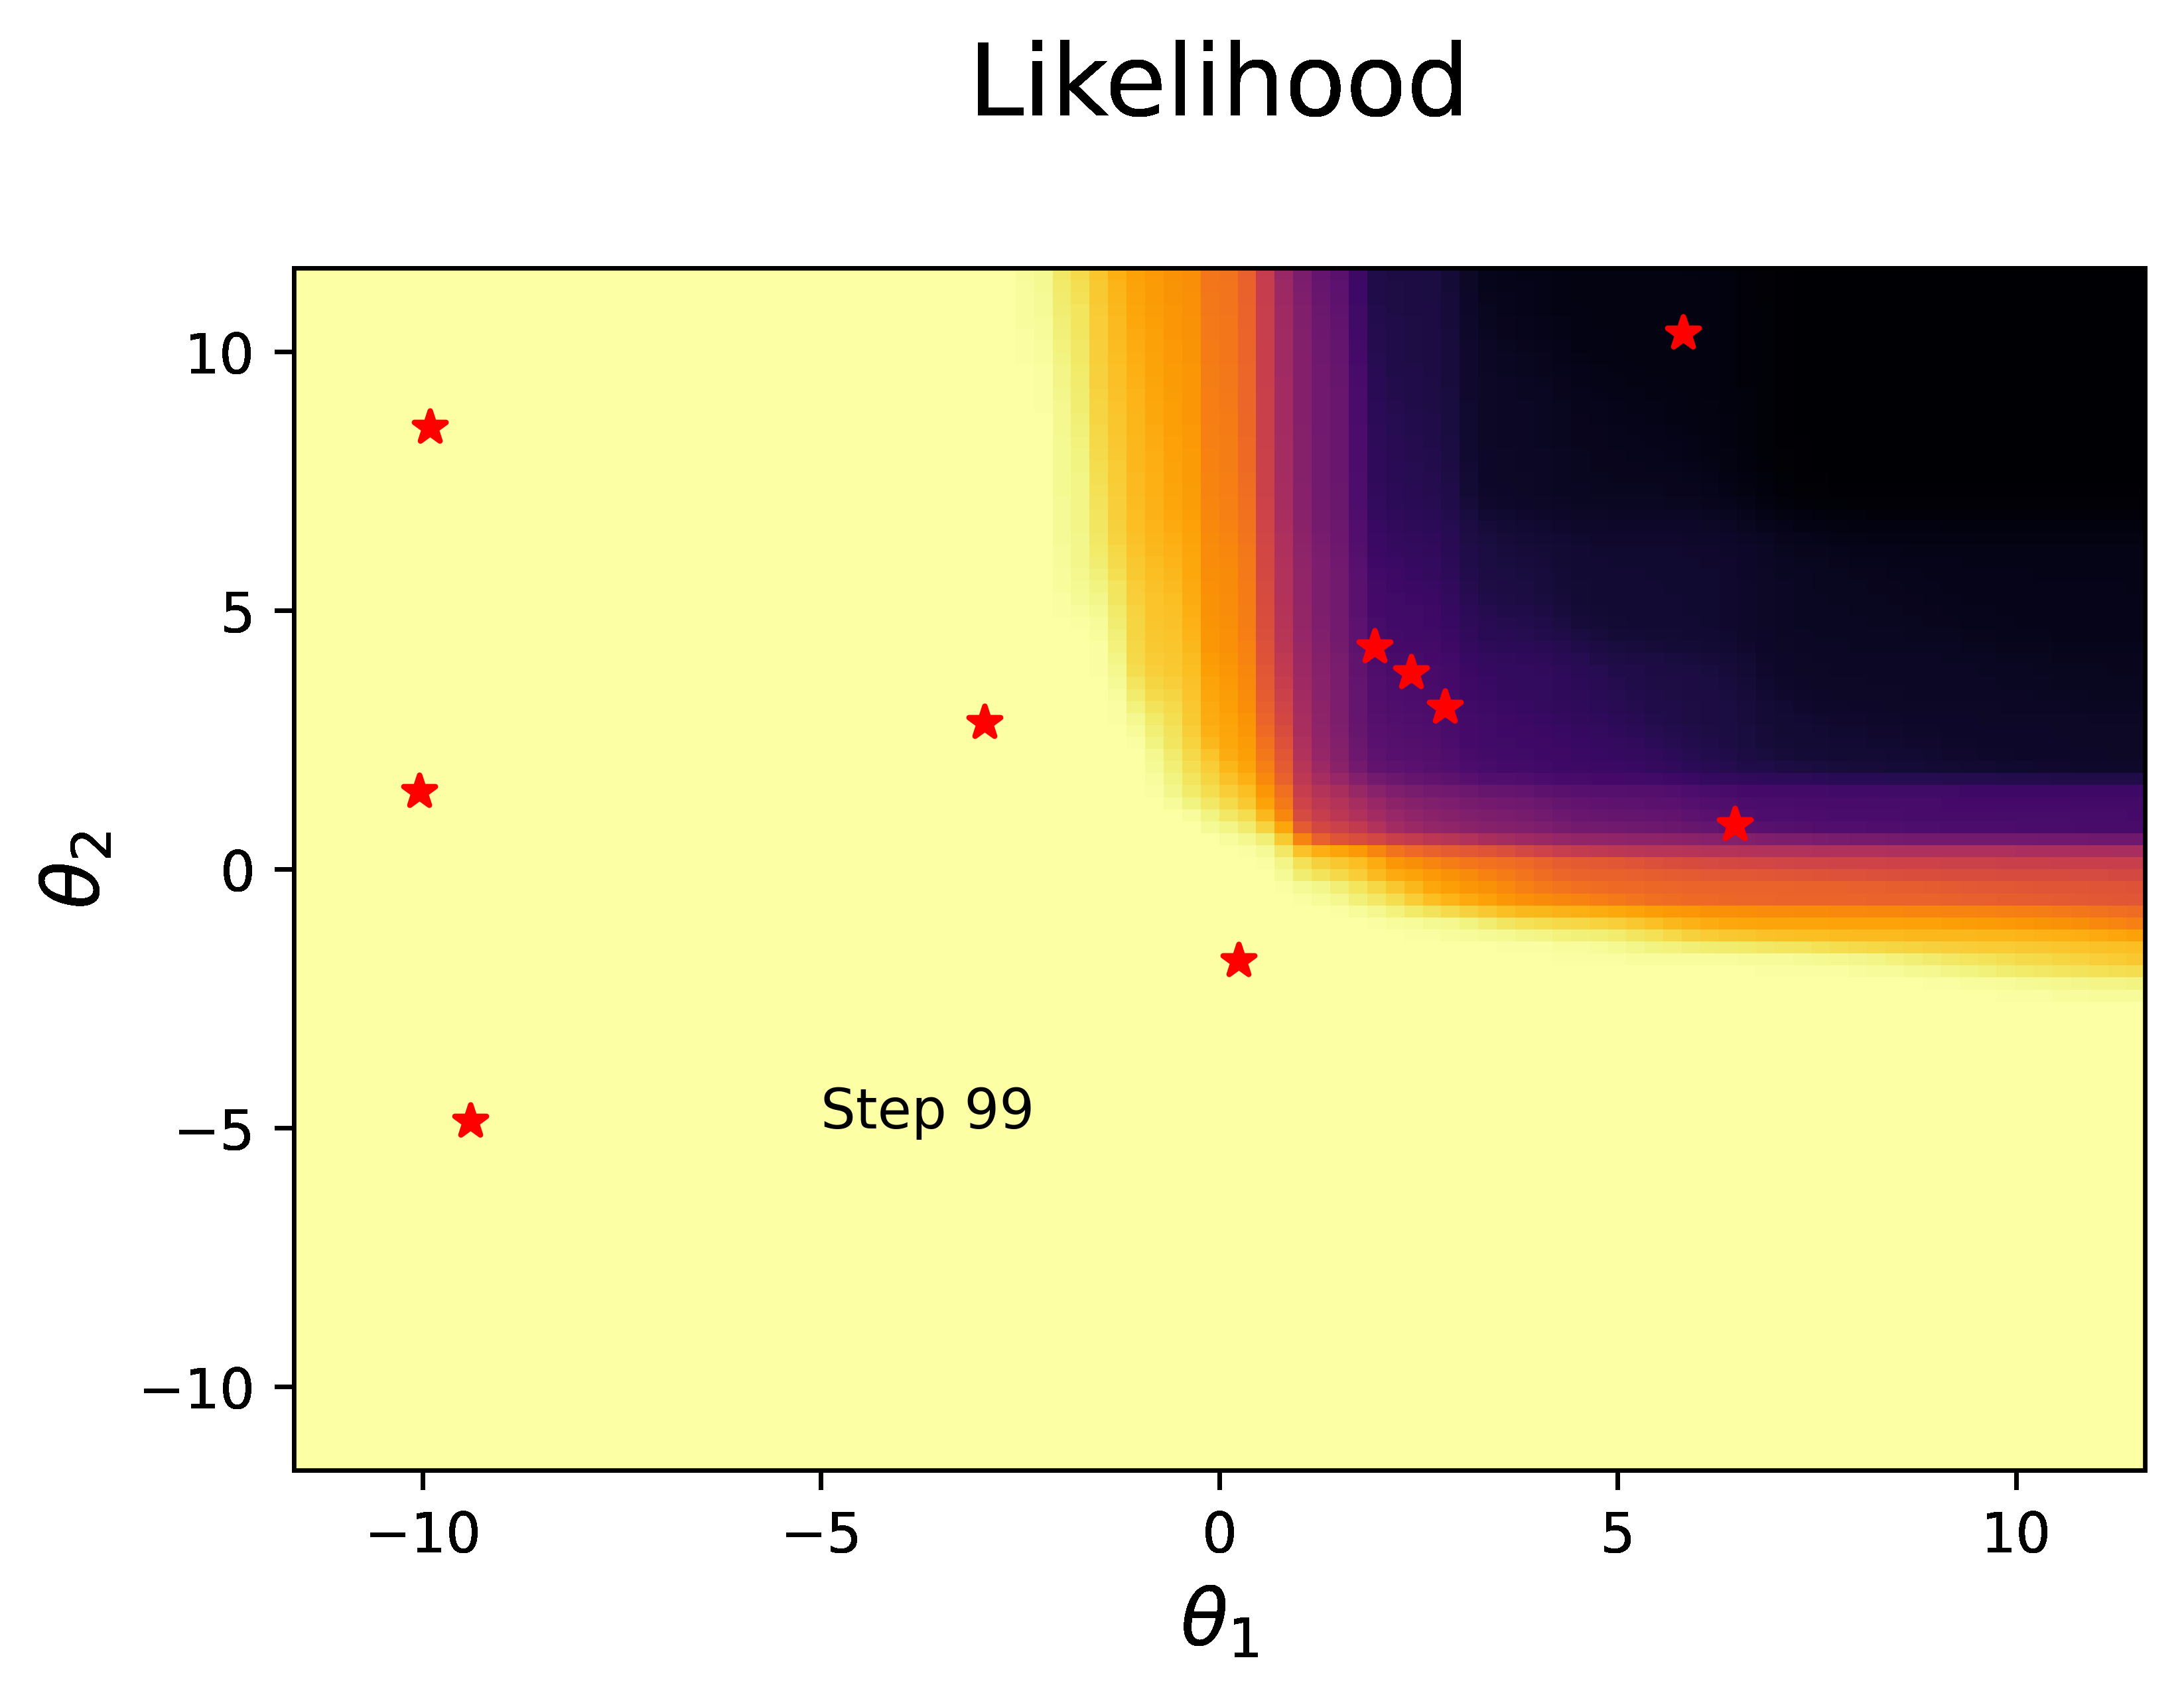

In [67]:
from utils_clean import get_likelihood_grids
x_grid, y_grid, z_grid = get_likelihood_grids(gpr_pso)
pso.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO_c1is0_c2is3.gif", show_zaeff=False)

In [5]:
df_results_c = pd.DataFrame({"Iteration":[], "c1":[], "c2":[], "Log Likelihood":[]})

In [6]:
c1 = [0, 0.3, 0.5, 1, 3]
c2 = [0, 0.3, 0.5, 1, 3]

for _c1 in c1:
    for _c2 in c2:
        for i in range(1):
            pso = PSOOptim(n_iters=100, n_particles=10, c1=_c1, c2=_c2, w=0.9, visualize=True)
            gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
            gpr_pso.fit(X.T, y[...,None])
            df_results_c.loc[len(df_results_c)] = [i, _c1, _c2, gpr_pso.log_marginal_likelihood_value_]

2022-08-09 17:03:45,973 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0, 'c2': 0, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=6.76e+4
2022-08-09 17:03:48,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 67612.50374706458, best pos: [-5.80815629  0.72104857]
2022-08-09 17:03:48,078 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.41e+4
2022-08-09 17:03:49,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34147.35053720791, best pos: [-1.03973599 -1.09335715]
2022-08-09 17:03:49,460 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.41e+4
2022-08-09 17:03:50,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34149.3500054834

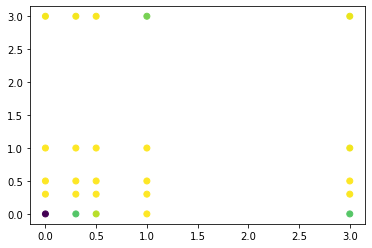

In [12]:
plt.scatter(df_results_c.c1, df_results_c.c2, c=df_results_c["Log Likelihood"])

In [10]:
df_results_c["Log Likelihood"]

0    -67612.503747
1    -34147.350537
2    -34149.350005
3    -34147.515435
4    -34768.230159
5    -43119.936271
6    -34146.969041
7    -34147.037809
8    -34153.325459
9    -34746.361256
10   -37756.551576
11   -34146.953861
12   -34146.939204
13   -34149.086895
14   -34458.402678
15   -34150.081554
16   -34146.932150
17   -34146.944634
18   -34150.081464
19   -40974.934587
20   -43002.719487
21   -34328.639970
22   -34210.999012
23   -34820.146992
24   -35281.356670
Name: Log Likelihood, dtype: float64